# Colab E-iii: TensorFlow Functional API - 3-Layer Deep Neural Network

## Overview
- **TensorFlow Functional API** (`tf.keras.Model` with explicit Input/Output)
- Allows complex model topologies (multi-input, multi-output, skip connections)
- Uses `model.compile()` and `model.fit()` for training
- Same 3-variable non-linear regression problem

### Target Non-Linear Equation
$$y = \sin(x_1) \cdot x_2^2 + \cos(x_3) \cdot x_1 + x_2 \cdot x_3^2$$

### Network Architecture (Functional API)
```
Input(3) --> Dense(64, ReLU) --> Dense(32, ReLU) --> Dense(16, ReLU) --> Dense(1)
```

In [1]:
# ============================================================
# Section 1: Imports
# ============================================================
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow: {tf.__version__}")
tf.random.set_seed(42)
np.random.seed(42)

TensorFlow: 2.19.0


In [2]:
# ============================================================
# Section 2: Generate Synthetic Data
# ============================================================
N_SAMPLES = 1000

x1 = np.random.uniform(-2, 2, (N_SAMPLES, 1)).astype(np.float32)
x2 = np.random.uniform(-2, 2, (N_SAMPLES, 1)).astype(np.float32)
x3 = np.random.uniform(-2, 2, (N_SAMPLES, 1)).astype(np.float32)

y = (np.sin(x1) * x2**2 + np.cos(x3) * x1 + x2 * x3**2).astype(np.float32)
X = np.hstack([x1, x2, x3])

X_mean, X_std = X.mean(axis=0), X.std(axis=0)
y_mean, y_std = y.mean(), y.std()
X_norm = ((X - X_mean) / X_std).astype(np.float32)
y_norm = ((y - y_mean) / y_std).astype(np.float32)

split = int(0.8 * N_SAMPLES)
X_train, X_test = X_norm[:split], X_norm[split:]
y_train, y_test = y_norm[:split], y_norm[split:]

print(f"Train: {X_train.shape}, Test: {X_test.shape}")
print(f"y = sin(x1)*x2² + cos(x3)*x1 + x2*x3²")

Train: (800, 3), Test: (200, 3)
y = sin(x1)*x2² + cos(x3)*x1 + x2*x3²


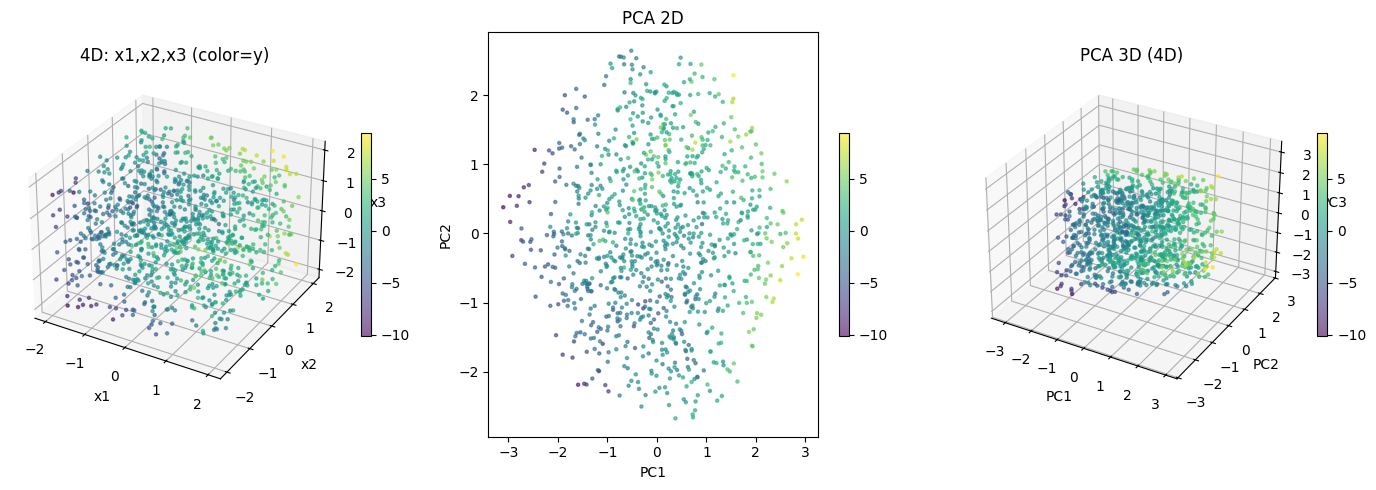

In [3]:
# ============================================================
# Section 3: 4D Data Visualization
# ============================================================
fig = plt.figure(figsize=(14, 5))

ax1 = fig.add_subplot(131, projection='3d')
sc1 = ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=y.flatten(), cmap='viridis', s=5, alpha=0.6)
ax1.set_xlabel('x1'); ax1.set_ylabel('x2'); ax1.set_zlabel('x3')
ax1.set_title('4D: x1,x2,x3 (color=y)')
plt.colorbar(sc1, ax=ax1, shrink=0.5)

pca2 = PCA(n_components=2); Xp2 = pca2.fit_transform(X)
ax2 = fig.add_subplot(132)
sc2 = ax2.scatter(Xp2[:, 0], Xp2[:, 1], c=y.flatten(), cmap='viridis', s=5, alpha=0.6)
ax2.set_xlabel('PC1'); ax2.set_ylabel('PC2'); ax2.set_title('PCA 2D')
plt.colorbar(sc2, ax=ax2, shrink=0.5)

pca3 = PCA(n_components=3); Xp3 = pca3.fit_transform(X)
ax3 = fig.add_subplot(133, projection='3d')
sc3 = ax3.scatter(Xp3[:, 0], Xp3[:, 1], Xp3[:, 2], c=y.flatten(), cmap='viridis', s=5, alpha=0.6)
ax3.set_xlabel('PC1'); ax3.set_ylabel('PC2'); ax3.set_zlabel('PC3')
ax3.set_title('PCA 3D (4D)')
plt.colorbar(sc3, ax=ax3, shrink=0.5)

plt.tight_layout()
plt.show()

Model: "ThreeLayerDNN_Functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_features (InputLayer)     │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_1 (Dense)                │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,881 (11.25 KB)

 Trainable params: 2,881 (11.25 KB)

 Non-trainable params: 0 (0.00 B)

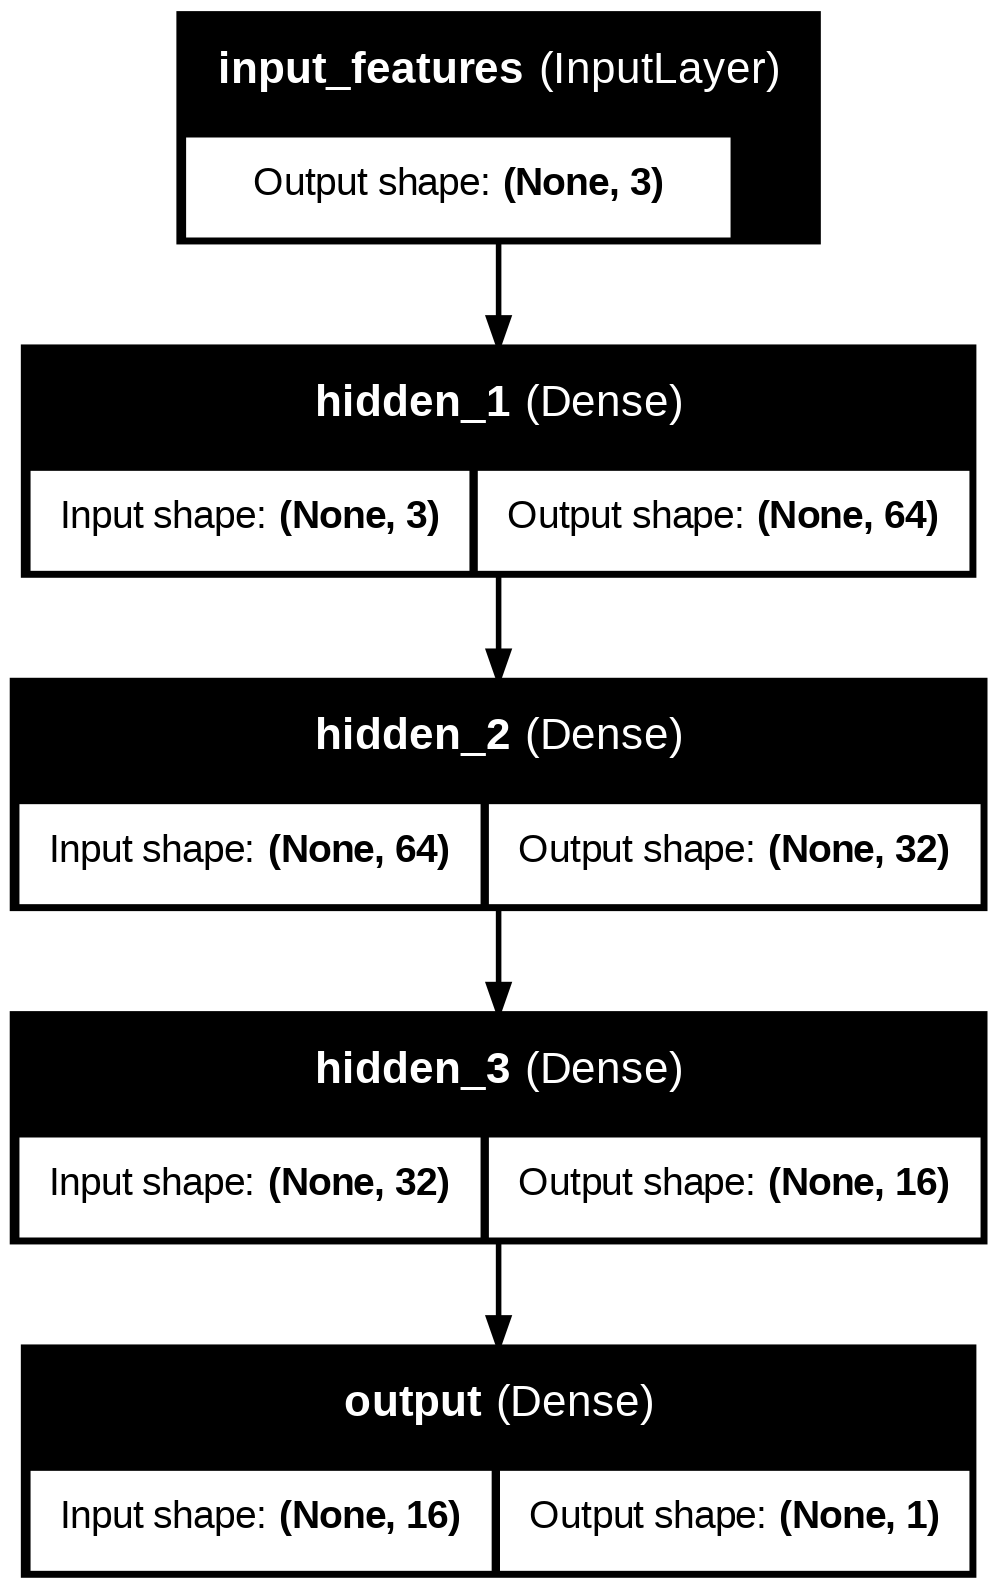

In [4]:
# ============================================================
# Section 4: Build Model Using Functional API
# ============================================================
# The Functional API defines the model as a DAG (Directed Acyclic Graph)
# Each layer is called on the output of the previous layer

def build_functional_model():
    """
    Build 3-Layer DNN using TensorFlow Functional API.

    Key difference from Sequential:
    - Explicit Input tensor
    - Model defined as a graph of layer calls
    - Supports complex topologies (multi-input/output, skip connections)
    """
    # Define input
    inputs = Input(shape=(3,), name='input_features')

    # Hidden Layer 1: 64 neurons, ReLU
    x = layers.Dense(64, activation='relu',
                     kernel_initializer='he_normal',
                     name='hidden_1')(inputs)

    # Hidden Layer 2: 32 neurons, ReLU
    x = layers.Dense(32, activation='relu',
                     kernel_initializer='he_normal',
                     name='hidden_2')(x)

    # Hidden Layer 3: 16 neurons, ReLU
    x = layers.Dense(16, activation='relu',
                     kernel_initializer='he_normal',
                     name='hidden_3')(x)

    # Output Layer: 1 neuron, Linear
    outputs = layers.Dense(1, name='output')(x)

    # Create Model
    model = Model(inputs=inputs, outputs=outputs, name='ThreeLayerDNN_Functional')
    return model

model = build_functional_model()
model.summary()

# Visualize model architecture
try:
    tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True,
                              to_file='functional_model.png')
    from IPython.display import Image
    display(Image('functional_model.png'))
except Exception as e:
    print(f"(Model plot visualization skipped: {e})")

In [5]:
# ============================================================
# Section 5: Compile and Train Model
# ============================================================

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50, verbose=1, min_lr=1e-6)
]

print("Training with model.fit() (Functional API)...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=500,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining complete!")

Training with model.fit() (Functional API)...
Epoch 1/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - loss: 1.1879 - mae: 0.7991 - val_loss: 0.4685 - val_mae: 0.5060 - learning_rate: 0.0010
Epoch 2/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4261 - mae: 0.4768 - val_loss: 0.2721 - val_mae: 0.4016 - learning_rate: 0.0010
Epoch 3/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2638 - mae: 0.3880 - val_loss: 0.1957 - val_mae: 0.3385 - learning_rate: 0.0010
Epoch 4/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1840 - mae: 0.3151 - val_loss: 0.1506 - val_mae: 0.2911 - learning_rate: 0.0010
Epoch 5/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1416 - mae: 0.2723 - val_loss: 0.1230 - val_mae: 0.2671 - learning_rate: 0.0010
Epoch 6/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1159 - mae: 0.2510 - val_loss: 0.1079 - val_mae: 0.2577 - learning_rate: 0.0010
Epoch 7/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0946 - mae: 0.2316 - val_loss: 0.0915 - val_m

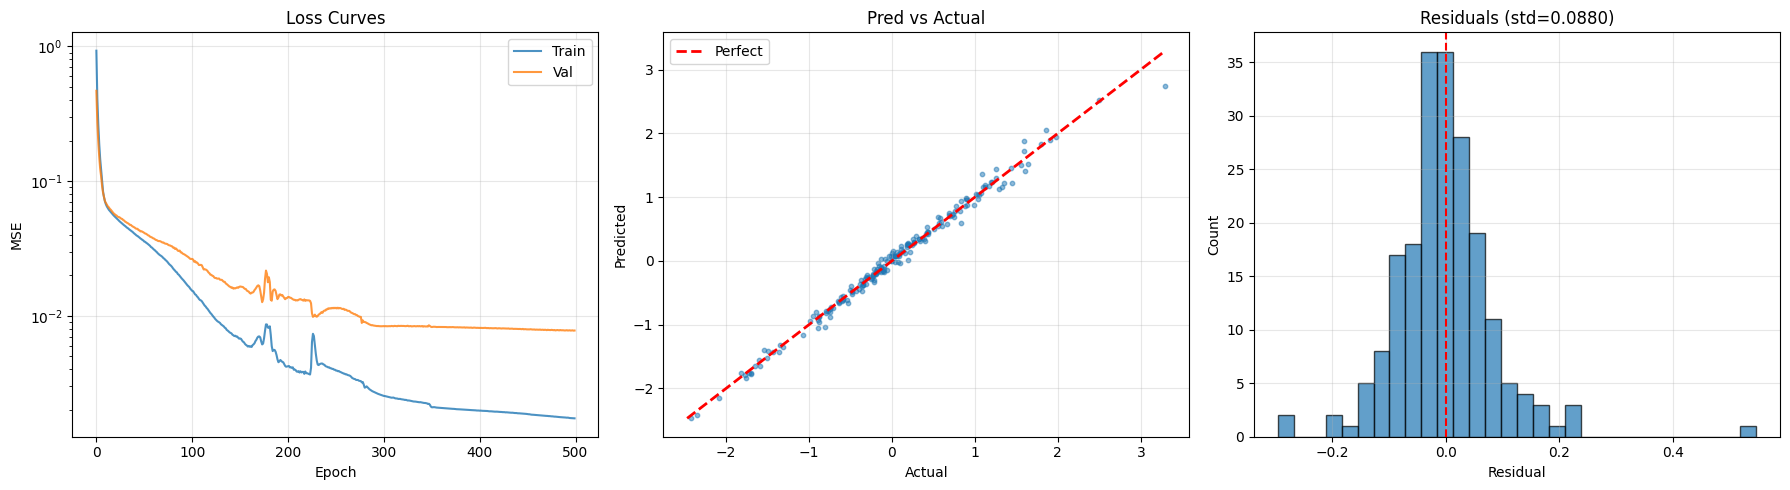

R²: 0.990563
MAE: 0.060747
Final train loss: 0.001730
Final val loss: 0.007768


In [6]:
# ============================================================
# Section 6: Results Visualization
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss curves from history
axes[0].plot(history.history['loss'], label='Train', alpha=0.8)
axes[0].plot(history.history['val_loss'], label='Val', alpha=0.8)
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('MSE')
axes[0].set_title('Loss Curves'); axes[0].legend()
axes[0].set_yscale('log'); axes[0].grid(True, alpha=0.3)

# Predictions
y_final = model.predict(X_test, verbose=0)

axes[1].scatter(y_test, y_final, alpha=0.5, s=10)
mn, mx = min(y_test.min(), y_final.min()), max(y_test.max(), y_final.max())
axes[1].plot([mn, mx], [mn, mx], 'r--', lw=2, label='Perfect')
axes[1].set_xlabel('Actual'); axes[1].set_ylabel('Predicted')
axes[1].set_title('Pred vs Actual'); axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Residuals
res = (y_test - y_final).flatten()
axes[2].hist(res, bins=30, edgecolor='black', alpha=0.7)
axes[2].axvline(0, color='r', linestyle='--')
axes[2].set_xlabel('Residual'); axes[2].set_ylabel('Count')
axes[2].set_title(f'Residuals (std={res.std():.4f})')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

r2 = 1 - np.sum(res**2) / np.sum((y_test.flatten() - y_test.mean())**2)
print(f"R²: {r2:.6f}")
print(f"MAE: {np.mean(np.abs(res)):.6f}")
print(f"Final train loss: {history.history['loss'][-1]:.6f}")
print(f"Final val loss: {history.history['val_loss'][-1]:.6f}")

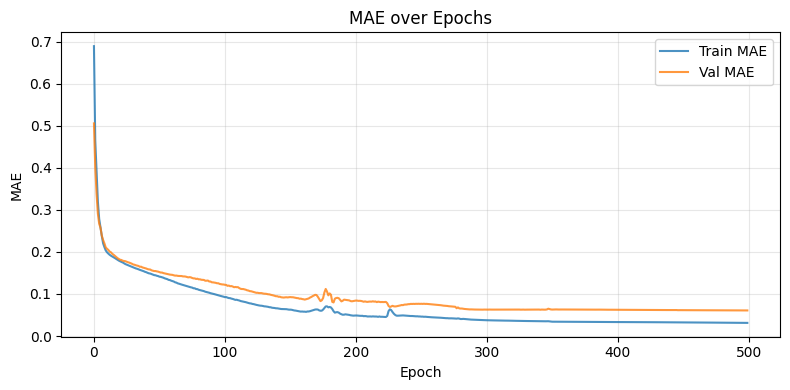


Sample Predictions (Original Scale):
  Idx |      x1 |      x2 |      x3 |    Actual |      Pred |     Err
----------------------------------------------------------------------
    0 |   0.829 |   1.826 |   1.170 |    5.2825 |    5.8302 |  0.5477
    1 |  -1.390 |   0.950 |   1.632 |    1.7257 |    1.5750 |  0.1507
    2 |   0.305 |  -0.587 |   1.775 |   -1.8073 |   -1.8261 |  0.0188
    3 |   0.427 |  -0.814 |   1.841 |   -2.5965 |   -2.2433 |  0.3532
    4 |  -0.303 |  -0.601 |   0.086 |   -0.4148 |   -0.1991 |  0.2157
    5 |   0.946 |   1.099 |   1.909 |    4.6694 |    4.3214 |  0.3480
    6 |   1.737 |   0.645 |   1.029 |    1.9903 |    2.0275 |  0.0372
    7 |   1.702 |  -1.259 |  -1.353 |   -0.3670 |   -0.4634 |  0.0965
    8 |  -0.197 |  -1.304 |  -0.092 |   -0.5389 |   -0.5405 |  0.0016
    9 |  -1.547 |  -1.606 |   0.873 |   -4.7987 |   -4.9620 |  0.1633
   10 |   1.939 |   0.641 |  -1.011 |    2.0689 |    2.0639 |  0.0050
   11 |   1.356 |   1.057 |   0.562 |    2.5738 |  

In [7]:
# ============================================================
# Section 7: Sample Predictions & MAE curve
# ============================================================

# MAE curve
plt.figure(figsize=(8, 4))
plt.plot(history.history['mae'], label='Train MAE', alpha=0.8)
plt.plot(history.history['val_mae'], label='Val MAE', alpha=0.8)
plt.xlabel('Epoch'); plt.ylabel('MAE')
plt.title('MAE over Epochs'); plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Denormalize
y_to = y_test * y_std + y_mean
y_po = y_final * y_std + y_mean
X_to = X_test * X_std + X_mean

print("\nSample Predictions (Original Scale):")
print("=" * 70)
print(f"{'Idx':>5} | {'x1':>7} | {'x2':>7} | {'x3':>7} | {'Actual':>9} | {'Pred':>9} | {'Err':>7}")
print("-" * 70)
for i in range(15):
    a, p = y_to[i,0], y_po[i,0]
    print(f"{i:5d} | {X_to[i,0]:7.3f} | {X_to[i,1]:7.3f} | {X_to[i,2]:7.3f} | {a:9.4f} | {p:9.4f} | {abs(a-p):7.4f}")

print(f"\nRMSE: {np.sqrt(np.mean((y_to-y_po)**2)):.4f}, R²: {r2:.6f}")

print("\n=== Colab E-iii Complete ===")
print("Key: TensorFlow Functional API")
print("- Input() + Dense() layer calls create a DAG")
print("- Model(inputs, outputs) wraps the graph")
print("- model.compile() + model.fit() for training")
print("- EarlyStopping + ReduceLROnPlateau callbacks")
print("- Supports complex topologies unlike Sequential")